In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

Using TensorFlow backend.


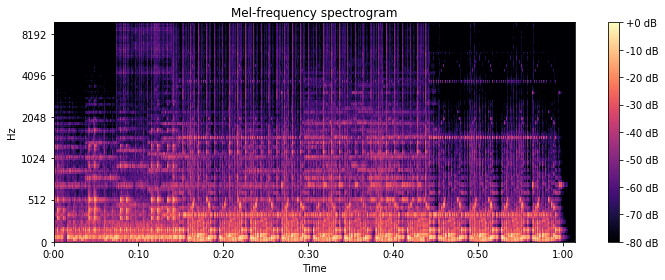

In [7]:
'''y, sr = librosa.load(librosa.util.example_audio_file())
S = librosa.feature.melspectrogram(y=y, sr=sr,
                                    fmax=8000)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=10000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()'''

In [2]:
def find_presence_compare(vocal,acc):
    th_factor=1
    th_all = np.mean((np.abs(vocal)))
    F = np.zeros((vocal.shape))
    for i in range(len(vocal)):
        threshold = th_factor*np.mean(np.abs(vocal[i,:]))
        for j in range(len(vocal[i])):
            F[i,j] = 1 if ( np.abs(vocal[i,j]) >=threshold and np.abs(vocal[i,j])>=th_all ) else 0
            if np.abs(vocal[i,j]) <=0.5*np.abs(acc[i,j]):
                F[i,j] = 0
    return F

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.1.0
/device:GPU:0
Num GPUs Available:  1


In [2]:
import musdb
mus = musdb.DB('~/pf/musdb18')

In [3]:
def stft_samples_from_audio(audio,is_vocal,n_stft_frames,rate):
    stft_samples = []
    f,t, stft_data = signal.stft(audio[:,0] + audio[:,1], rate, nperseg=1024,noverlap=512)
    if is_vocal:
        for j in range(len(stft_data.transpose())-n_stft_frames):
            stft_samples.append(stft_data[:,j+int(n_stft_frames/2)])
    else:
        for j in range(len(stft_data.transpose())-n_stft_frames):
            stft_samples.append(stft_data[:,j:j+n_stft_frames])
    return stft_samples

In [4]:
num_seg = 10
num_samples = num_seg*mus[0].rate
f,t, stft_data = signal.stft(mus[1].targets['vocals'].audio[0:num_samples,0] + mus[1].targets['vocals'].audio[0:num_samples,1], mus[1].rate, nperseg=1024,noverlap=256)
np.ceil(num_samples/1024) * 2 + 1

863.0

In [5]:
track_list = []
vocal_list = []
stft_list = []
vocal_stft_list = []
num_seg = 10
num_samples = num_seg*mus[0].rate
num_freq = 512
shape = (len(mus),num_freq+1,int(np.ceil(num_samples/(2*num_freq))*2+1))
stft_list = np.zeros(shape,dtype=complex)
vocal_stft_list = np.zeros(shape,dtype=complex)

for i in tqdm(range(len(mus))):
    track = mus[i]
    interval_start = int(np.random.uniform(0, len(track.audio)-num_samples))
    f,t, stft_data = signal.stft(track.audio[interval_start:interval_start + num_samples,0] + track.audio[interval_start:interval_start + num_samples,1], track.rate, nperseg=(2*num_freq),noverlap=num_freq)
    stft_list[i] = stft_data
    f,t, vocal_stft =  signal.stft(track.targets['vocals'].audio[interval_start:interval_start + num_samples,0] + track.targets['vocals'].audio[interval_start:interval_start + num_samples,1], track.rate,nperseg=1024,noverlap=512)
    #f,t, acc_stft = signal.stft(track.targets['accompaniment'].audio[0:num_samples,0] + track.targets['accompaniment'].audio[0:num_samples,1], track.rate,nperseg=1024,noverlap=512)

    vocal_stft_list[i] = vocal_stft

100%|██████████| 150/150 [17:35<00:00,  7.04s/it]


In [40]:
stft_list.shape

(150, 513, 863)

In [21]:
ipd.Audio(track.audio[0:num_samples,0],rate=mus[0].rate)

2585


[0, 10, 0, 20000]

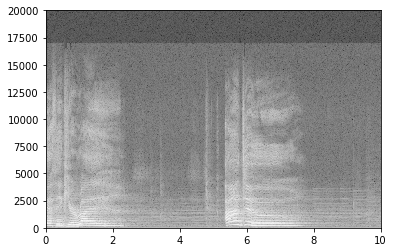

In [26]:
import matplotlib.cm as cm
num_seg = 30
num_samples = num_seg*mus[0].rate
f,t, stft_data = signal.stft(mus[0].targets['vocals'].audio[0:num_samples,0] + mus[0].targets['vocals'].audio[0:num_samples,1], mus[0].rate,nperseg=1024,noverlap=512)
print(len(stft_data[1]))

i = 3

freq_bins = 513
plt.pcolormesh(t, f, np.log(np.abs(stft_data)+1e-30),cmap=cm.gray)
xmin =0
xmax =10
ymin =0
ymax = 20000

plt.axis([xmin, xmax, ymin, ymax])

In [39]:
vocal_stft_list[0][:,0:25].shape

(513, 25)

In [6]:
train_data_groups = []
target_groups = []
sample_len = 25
freq_bins = 513

for i in tqdm(range(len(vocal_stft_list))):
  for j in range(len(vocal_stft_list[i].transpose())-sample_len):
    train_data_groups.append(np.log(np.abs(stft_list[i][:,j:j+sample_len])+1e-30))
    target_groups.append(np.log(np.abs(vocal_stft_list[i][:,j+int(sample_len/2)])+1e-30))


'''target_groups = np.asarray(target_groups)
train_data_groups = np.asarray(train_data_groups)'''



100%|██████████| 150/150 [00:47<00:00,  3.16it/s]


'target_groups = np.asarray(target_groups)\ntrain_data_groups = np.asarray(train_data_groups)'

In [9]:
'''for i in tqdm(range(0,len(target_groups),10000)):
  path = 'target_groups' + str(i) +'.npy'
  np.save(path,target_groups[i:i+10000])
  path = 'train_data_groups'+ str(i) + '.npy'
  np.save(path,train_data_groups[i:i+10000])
  path = 'len.npy' 
  np.save(path,len(train_data_groups))
'''
import h5py

hf = h5py.File('data_raw.h5', 'w')


hf.create_dataset('X_train', data=train_data_groups)
hf.create_dataset('Y_train', data=target_groups)

hf.close()
path = 'len_raw.npy' 
np.save(path,len(train_data_groups))



In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1,
                shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path = ''

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            group_size = 10000
            file_num = str(floor(i/group_size)*group_size)
            # Store sample
            X[i,] = np.load(self.path + 'train_data_groups' + file_num + '.npy')[i%group_size]

            # Store class
            y[i] = np.load(self.path + 'target_groups' + file_num + '.npy')[i%group_size]


        return X, y

In [ ]:
train_data_groups.shape

In [ ]:
target_groups[0].shape

In [ ]:
a = train_data_groups

plt.pcolormesh(t[i:i+sample_len], f, np.abs(a[0]))

In [ ]:
a = target_groups[0:100].transpose()

plt.pcolormesh(t[0:100], f, np.abs(a))

In [ ]:
a.shape

In [ ]:
num_samples/5

In [ ]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(Conv2D(16, (3,3), padding='same', input_shape=(freq_bins, sample_len, 1)))
  model.add(LeakyReLU())
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.25))
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(Conv2D(16, (3,3), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))
  model.add(Dense(freq_bins, activation='relu'))
  model.compile(loss=keras.losses.mse, optimizer='adam', metrics=['mse'])

In [ ]:
from keras_tqdm import TQDMNotebookCallback

with tf.device('/device:GPU:0'):
  history = model.fit(np.abs(train_data_groups).reshape(target_groups.shape[0],freq_bins,sample_len,1),np.abs(target_groups),batch_size = 32,epochs = 30)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
a = model.predict(np.abs(train_data_groups[0:1*len(stft_list[0][0])].reshape(len(stft_list[0][0]),513,11,1)))
test = np.transpose(a)
test_list = []
for i in range(len(test)):
  test_list.append(np.roll(test[i],2))
test = np.array(test_list)

In [ ]:
len(stft_list[0][0])

In [ ]:
result_stft = np.multiply(test,stft_list[0])
plt.pcolormesh(t, f, np.abs(result_stft))
xmin =0
xmax = 3
ymin =0
ymax = 3000

plt.axis([xmin, xmax, ymin, ymax])


In [ ]:
plt.pcolormesh(t, f, np.abs(vocal_stft_list[2]))
xmin =0
xmax = 30
ymin =0
ymax = 3000

plt.axis([xmin, xmax, ymin, ymax])

In [ ]:
audio1 = signal.istft(result_stft,fs =mus[0].rate)
audio1

In [ ]:
ipd.Audio(audio1[1],rate=mus[0].rate)

In [ ]:
ipd.Audio(mus[10].audio[:,0] + mus[10].audio[:,1],rate=mus[0].rate)